In [4]:
import numpy as np
import matplotlib.pyplot as plt
from augment3D import Augment3D

# Demo Functions (Safe to Ignore)

In [5]:
# functions to draw spheres on 3D volumes, for demo only
def cmask(index, radius, shape):
    a, b, c = index
    nx, ny, nz = shape
    y, x, z = np.ogrid[
        -a: nx - a, 
        -b: ny - b, 
        -c: nz - c
    ]
    mask = x * x + y * y + z * z <= radius * radius * radius
    return mask

def draw_circle_on(img, r, value, center=None):
    x, y, z = img.shape 
    if center is None:
        xc, yc, zc = x//2, y//2, z//2
    else:
        xc, yc, zc = center
    mask = cmask((xc, yc, zc), r, (x, y, z))
    img = img[:, :, :]
    img[mask] = value
    return img

def axial_viz(img, plot_name):
    if len(img.shape) == 3:
        x, y, z = img.shape
    elif len(img.shape) == 4:
        x, y, z, _ = img.shape
        img = img.reshape((x, y, z))
    xc, yc, zc = x//2, y//2, z//2
    
    fig = plt.figure(figsize=(10, 5))
    fig.suptitle(plot_name)
    ax1 = plt.subplot(1, 3, 1)
    plt.imshow(img[xc, :, :])
    ax1.title.set_text('Dim1')
    
    ax2 = plt.subplot(1, 3, 2)
    plt.imshow(img[:, yc, :])
    ax2.title.set_text('Dim2')

    ax3 = plt.subplot(1, 3, 3)
    plt.imshow(img[:, :, zc])
    ax3.title.set_text('Dim3')


# 1. Generate a 3D Image and a "Segementation" for Demo
The generated image and segmentation have the same patterns and shape (dim1, dim2, dim3).

In [6]:
# make image and segmentation
shape = [64, 64, 64] # [batch_size, h, w, channels]
img = np.zeros(shape)
img = draw_circle_on(img, 10, 4)
img = draw_circle_on(img, 8, 5)
img = draw_circle_on(img, 6, 6)
img = draw_circle_on(img, 4, 7)
img = draw_circle_on(img, 3, 8, center=(32, 32, 5))
img = draw_circle_on(img, 3, 9, center=(5, 32, 32))

seg = np.zeros(shape)
seg = draw_circle_on(seg, 10, 1)
seg = draw_circle_on(seg, 8, 2)
seg = draw_circle_on(seg, 6, 3)
seg = draw_circle_on(seg, 4, 4)
seg = draw_circle_on(seg, 3, 5, center=(32, 32, 5))
seg = draw_circle_on(seg, 3, 6, center=(5, 32, 32))


## Visualise axial views:

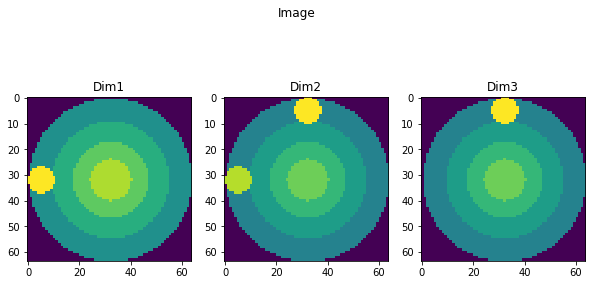

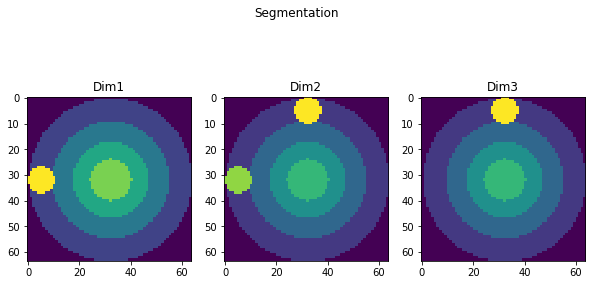

In [7]:
axial_viz(img, "Image")
axial_viz(seg, "Segmentation")

# 2 Prepare Images for Augmentation
Reshape and convert the image and the segmentation mask.


In [8]:
# Add an extra dimension (channel)
image = np.expand_dims(img, -1)
image.shape

(64, 64, 64, 1)

In [9]:
# Use the provided util function to convert the segmentation mask to one-hot format.
from utils import to_channels
segmentation = to_channels(seg)
segmentation.shape

(64, 64, 64, 7)

In [10]:
# Training batch containing 3 examples
imgs = [
    image, 
    image, 
    image, 
]
segs = [
    segmentation, 
    segmentation, 
    segmentation
]

# 3. Apply Augmentation Using `Augement3D`

## 3.1 Random Shift
Use shift augmentation by invoking `augmentor.add_shifts([dx, dy, dz])`. `dx, dy` and `dz` defines the upper limit (in pixels) of random shifts that can be applied.


In [11]:
augmentor = Augment3D()
augmentor.add_shifts([20, 20, 20]) # can shift at most 20 pixels per dimension
augmentor.summary()
augmented = augmentor.apply_augmentation_to_batch(imgs, segs)

# index 0: image, index 1: segmentation mask
augmented_imgs = augmented[0]
augmented_segs = augmented[1]

=============== Augmentation Functions ===============


Use our helper function to visualise the first image.

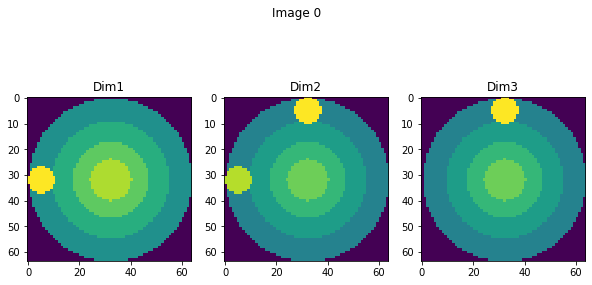

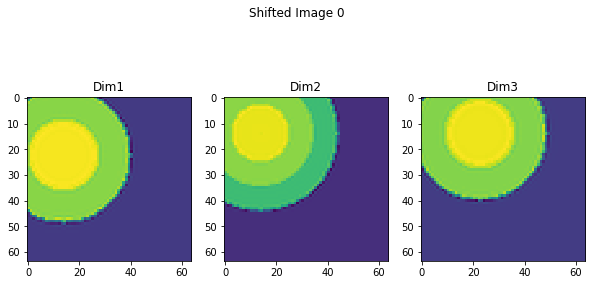

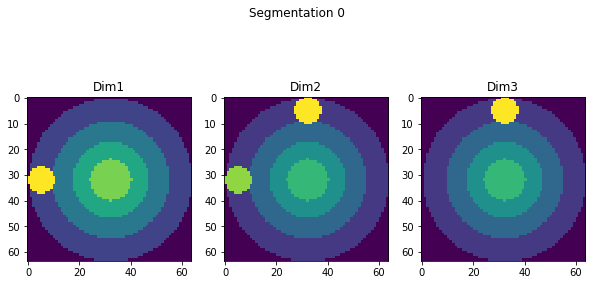

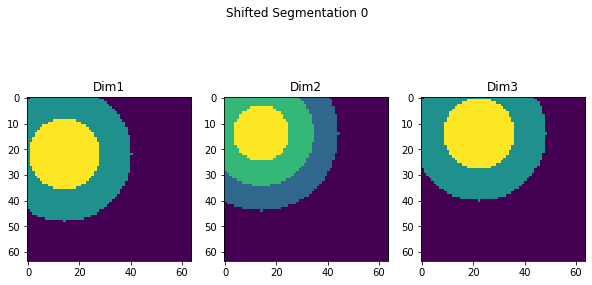

In [12]:
# visualise
augmented_segs_combined = [np.argmax(img, axis=-1) for img in augmented_segs]
axial_viz(img, "Image 0")
axial_viz(augmented_imgs[0], "Shifted Image 0")
axial_viz(seg, "Segmentation 0")
axial_viz(augmented_segs_combined[0], "Shifted Segmentation 0")

In [13]:
augmentor = Augment3D()
augmentor.add_uniaxial_rotation(50) # max 50 degrees
augmentor.summary()
augmented = augmentor.apply_augmentation_to_batch(imgs, segs)

# index 0: image, index 1: segmentation mask
augmented_imgs = augmented[0]
augmented_segs = augmented[1]

=============== Augmentation Functions ===============


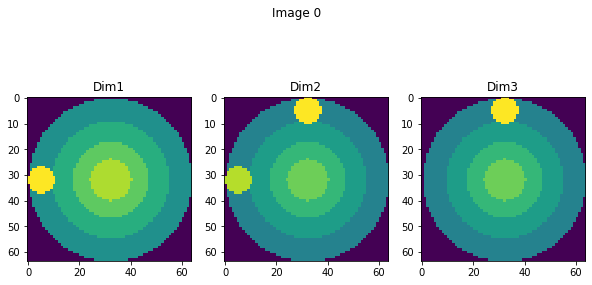

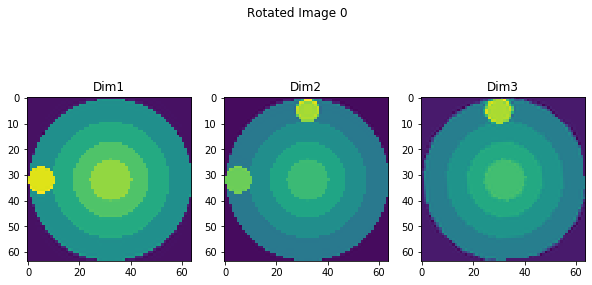

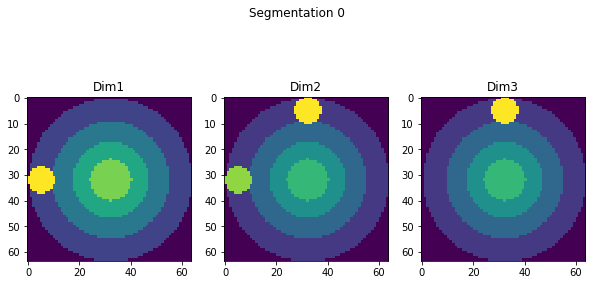

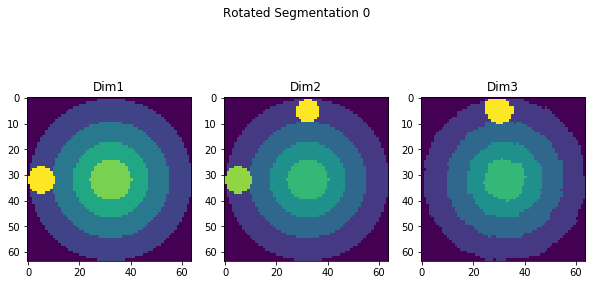

In [14]:
# visualise
augmented_segs_combined = [np.argmax(img, axis=-1) for img in augmented_segs]
axial_viz(img, "Image 0")
axial_viz(augmented_imgs[0], "Rotated Image 0")
axial_viz(seg, "Segmentation 0")
axial_viz(augmented_segs_combined[0], "Rotated Segmentation 0")


## 3.3 Random Elastic Deform
Use shift augmentation by invoking `augmentor.add_elastic_deformation(sigma, possible_points)`. `sigma` defines the maximum sigma value allowed for the deform strength, `possible_points` is a list of integers definine the number of points to use. (e.g. if `possible_points=[2, 3, 4]`, the augmentation will be performed with 2, 3 or 4 points (chosen randomly)).

In [15]:
augmentor = Augment3D()
augmentor.add_elastic_deformation(10, [3, 4, 5, 6])
augmentor.summary()
augmented = augmentor.apply_augmentation_to_batch(imgs, segs)

# index 0: image, index 1: segmentation mask
augmented_imgs = augmented[0]
augmented_segs = augmented[1]

=============== Augmentation Functions ===============


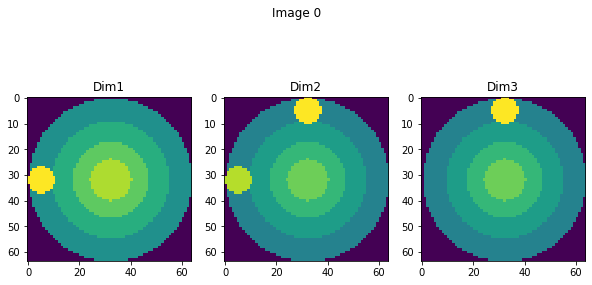

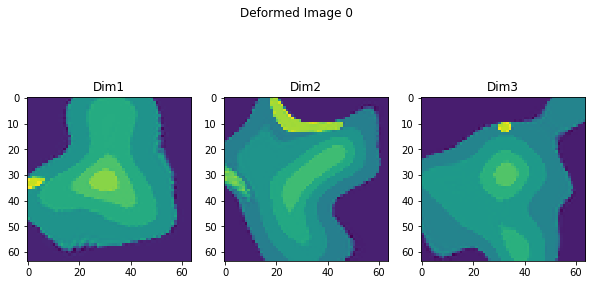

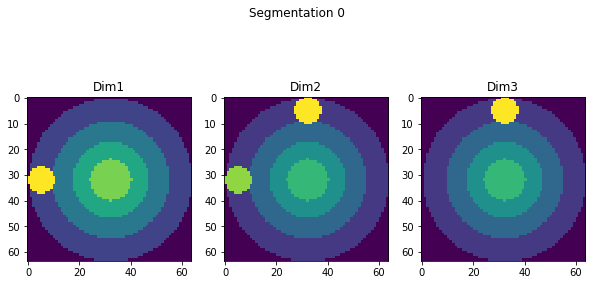

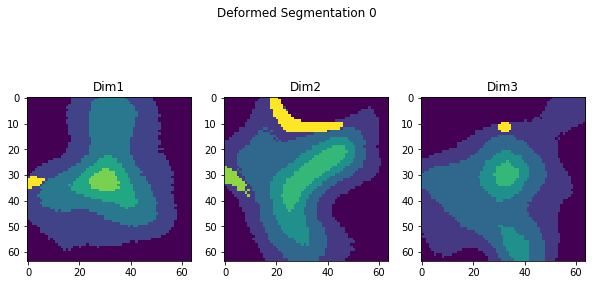

In [16]:
# visualise
augmented_segs_combined = [np.argmax(img, axis=-1) for img in augmented_segs]
axial_viz(img, "Image 0")
axial_viz(augmented_imgs[0], "Deformed Image 0")
axial_viz(seg, "Segmentation 0")
axial_viz(augmented_segs_combined[0], "Deformed Segmentation 0")

## 3.3 Random Affine Warp
Use shift augmentation by invoking `augmentor.add_affine_warp(delta)`. `delta` defines the maximum shift (in pixels) applied to each of the 8 vertices of the image. 

In [17]:
augmentor = Augment3D()
augmentor.add_affine_warp(20)
augmentor.summary()
augmented = augmentor.apply_augmentation_to_batch(imgs, segs)

# index 0: image, index 1: segmentation mask
augmented_imgs = augmented[0]
augmented_segs = augmented[1]

=============== Augmentation Functions ===============


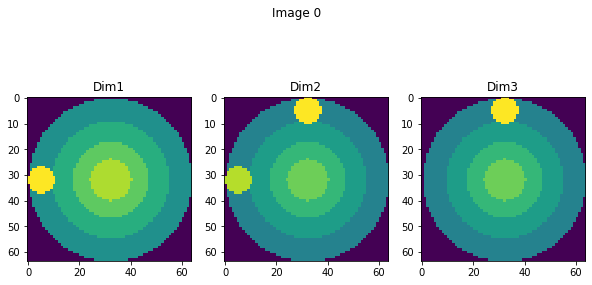

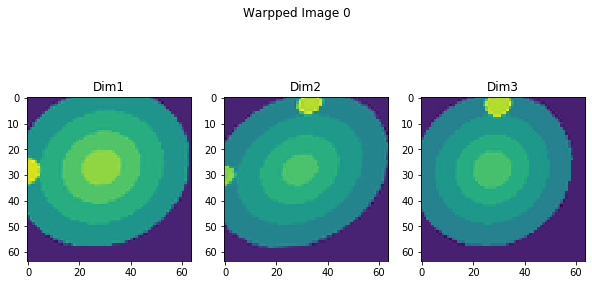

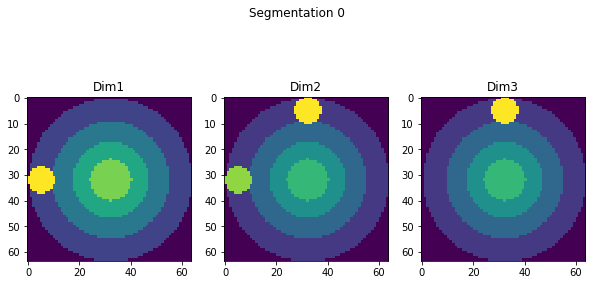

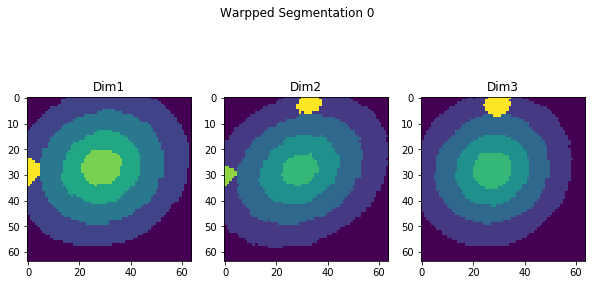

In [18]:
# visualise
augmented_segs_combined = [np.argmax(img, axis=-1) for img in augmented_segs]
axial_viz(img, "Image 0")
axial_viz(augmented_imgs[0], "Warpped Image 0")
axial_viz(seg, "Segmentation 0")
axial_viz(augmented_segs_combined[0], "Warpped Segmentation 0")